In [2]:
import pandas as pd
import os

# Utiliser le dossier courant comme base (par défaut dans les notebooks)
base_dir = os.getcwd()

# Chemins des sous-dossiers pour train et test
file_path = os.path.join(base_dir, r'data\donnees-historiques\prix\hourly_day_ahead_prices_2017_2020.parquet')
file_path2 = os.path.join(base_dir, r'data\scenarios-synthetiques\prix\00257.parquet')

data1 = pd.read_parquet(file_path)
data2 = pd.read_parquet(file_path2)


horizons = [6, 12, 24, 48, 72, 168]  # En heures





In [32]:
# Pour le dataset des prix
print(data1.isnull().sum())

# Pour le dataset des scénarios
print(data2.isnull().sum())


price    0
dtype: int64
price        0
dayofweek    0
hourofday    0
dtype: int64


In [33]:
print(f"Dupliqués dans les prix : {data1.duplicated().sum()}")
print(f"Dupliqués dans les scénarios : {data2.duplicated().sum()}")


Dupliqués dans les prix : 27230
Dupliqués dans les scénarios : 13389


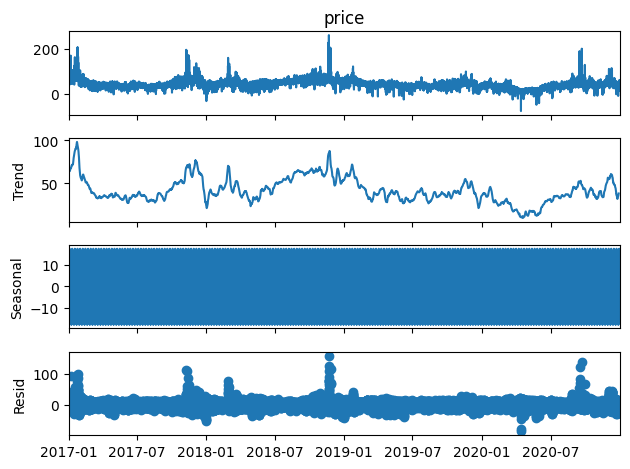

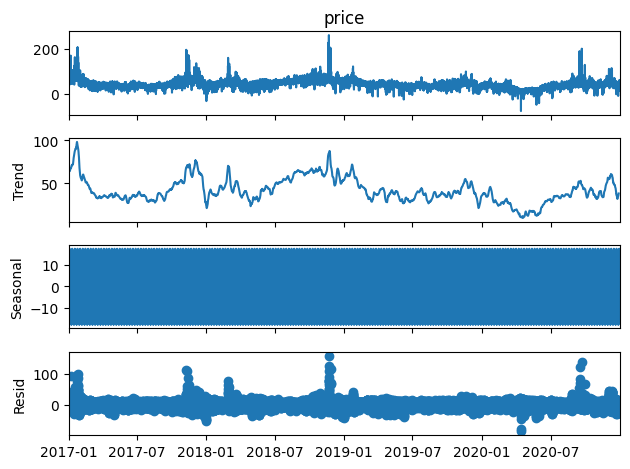

In [44]:
# Decomposition des séries temporelles
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data1['price'], model='additive', period=24*7)  # Période hebdomadaire
result.plot()


### Analyse dataset prix

In [34]:
print(f"Plage temporelle : {data1.index.min()} à {data1.index.max()}")


Plage temporelle : 2016-12-31 23:00:00+00:00 à 2020-12-31 22:00:00+00:00


In [3]:
# Aperçu des données
print(data1.head(5))
# Nombre de lignes et de colonnes
print(f"Nombre de lignes: {data1.shape[0]}")
print(f"Nombre de colonnes: {data1.shape[1]}")


# Types des colonnes
print(data1.dtypes)


                           price
date                            
2016-12-31 23:00:00+00:00  58.82
2017-01-01 00:00:00+00:00  58.23
2017-01-01 01:00:00+00:00  51.95
2017-01-01 02:00:00+00:00  47.27
2017-01-01 03:00:00+00:00  45.49
Nombre de lignes: 35064
Nombre de colonnes: 1
price    float64
dtype: object


In [35]:
print(data1['price'].describe())


count    35064.000000
mean        41.697606
std         18.600285
min        -75.820000
25%         30.180000
50%         39.900000
75%         51.422500
max        259.950000
Name: price, dtype: float64


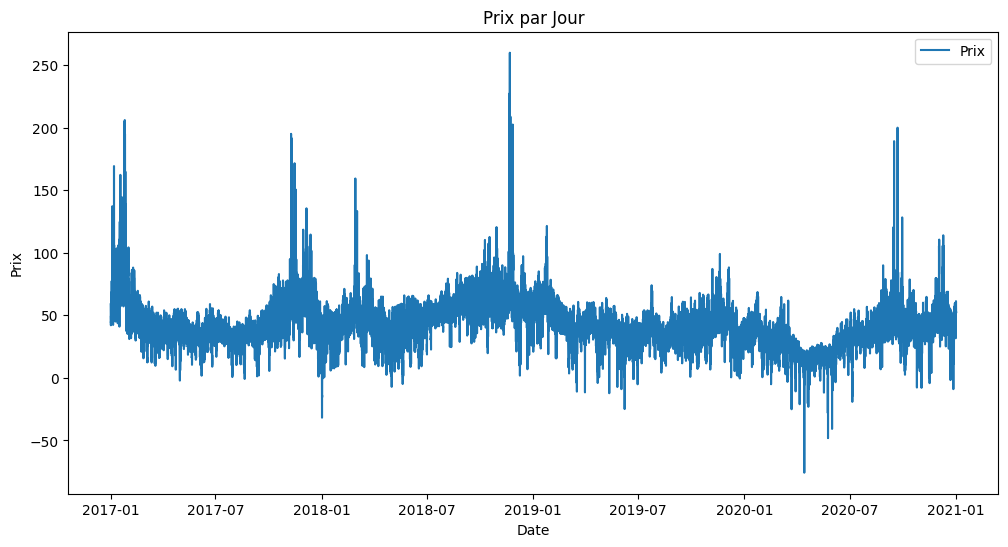

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data1.index, data1['price'], label='Prix')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('Prix par Jour')
plt.legend()
plt.show()


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

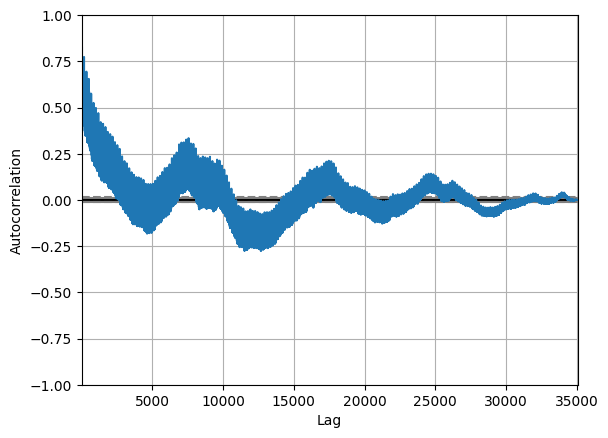

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data1['price'])



### Identifier les saisonalité, les tendances et les résidus (anomalie)

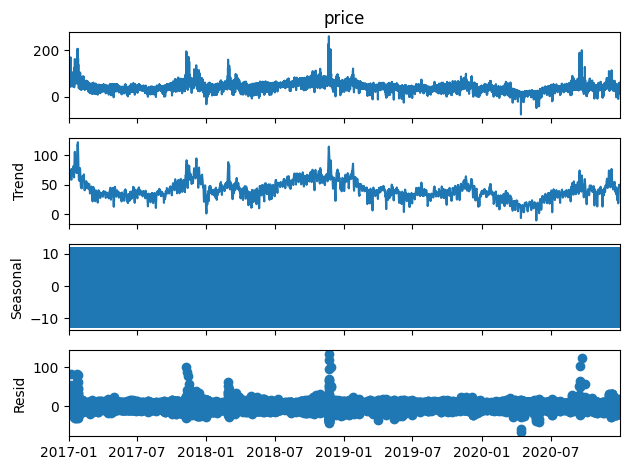

In [48]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Décomposition de la série temporelle
result = seasonal_decompose(data1['price'], model='additive', period=24)  # Période = 24 (journée pour données horaires)
result.plot()
plt.show()

# Examiner les composantes
trend = result.trend
seasonal = result.seasonal
residual = result.resid



### Creation de feature temporelle

In [49]:
# Ajouter des features basées sur l'index temporel
data1['hour'] = data1.index.hour
data1['day_of_week'] = data1.index.dayofweek
data1['is_weekend'] = data1['day_of_week'] >= 5

# Ajouter des décalages temporels (lag features)
data1['price_lag_1'] = data1['price'].shift(1)  # Lag de 1
data1['price_lag_24'] = data1['price'].shift(24)  # Lag d'une journée (pour données horaires)

# Supprimer les lignes avec des NaN (causés par les lags)
data1.dropna(inplace=True)


In [50]:
data1['hour'].head(5)

date
2017-01-01 23:00:00+00:00    23
2017-01-02 00:00:00+00:00     0
2017-01-02 01:00:00+00:00     1
2017-01-02 02:00:00+00:00     2
2017-01-02 03:00:00+00:00     3
Name: hour, dtype: int32

### Normalisation des colomnes pour l'entrainement

In [51]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation des colonnes numériques
scaler = MinMaxScaler()
data1[['price_scaled', 'price_lag_1', 'price_lag_24']] = scaler.fit_transform(data1[['price', 'price_lag_1', 'price_lag_24']])


### DATASET 2 des scénarios

In [42]:
# Aperçu des données
print(data2.tail(5))
# Nombre de lignes et de colonnes
print(f"Nombre de lignes: {data2.shape[0]}")
print(f"Nombre de colonnes: {data2.shape[1]}")


# Types des colonnes
print(data2.dtypes)

       price  dayofweek  hourofday
34939  38.66          6         19
34940  38.98          6         20
34941  35.96          6         21
34942  45.13          6         22
34943  24.60          6         23
Nombre de lignes: 34944
Nombre de colonnes: 3
price        float64
dayofweek      int32
hourofday      int32
dtype: object


In [37]:
# Distribution des prix
print(data2['price'].describe())

# Vérifie les valeurs uniques pour dayofweek et hourofday
print(f"Jours uniques : {data2['dayofweek'].unique()}")
print(f"Heures uniques : {data2['hourofday'].unique()}")


count    34944.000000
mean        40.218429
std         16.755465
min        -48.170000
25%         29.910000
50%         38.790000
75%         49.390000
max        227.220000
Name: price, dtype: float64
Jours uniques : [0 1 2 3 4 5 6]
Heures uniques : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


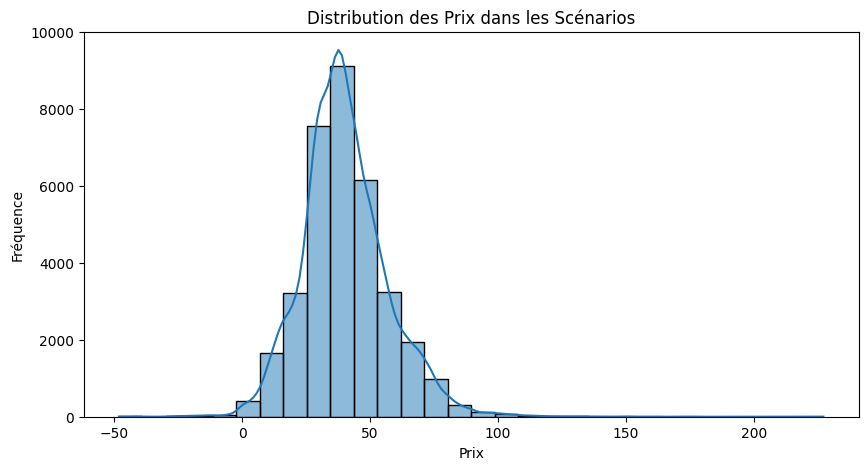

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data2['price'], bins=30, kde=True)
plt.title('Distribution des Prix dans les Scénarios')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()


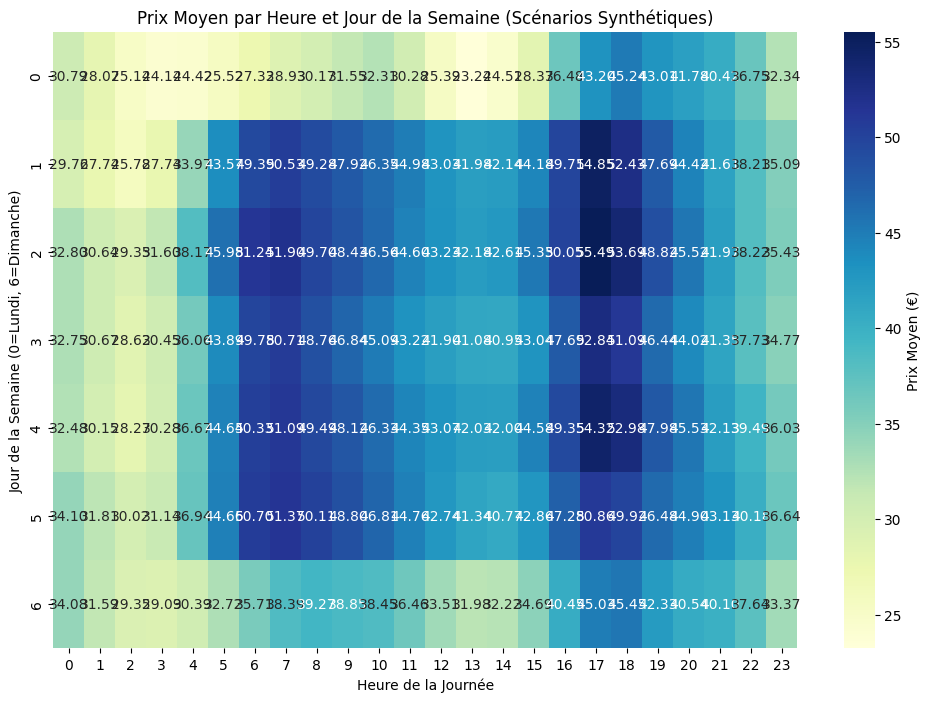

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer la moyenne des prix par jour de la semaine et heure
heatmap_data = data2.groupby(['dayofweek', 'hourofday'])['price'].mean().unstack()

# Créer la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Prix Moyen (€)'})
plt.title("Prix Moyen par Heure et Jour de la Semaine (Scénarios Synthétiques)")
plt.xlabel("Heure de la Journée")
plt.ylabel("Jour de la Semaine (0=Lundi, 6=Dimanche)")

plt.show()
